# Plotting Features

### Introduction

In previous lessons, we reduced our features to a small subset from what we originally began with.  Now that we have identified a subset of features to focus on, it's time for us to see how they relate to our target variable, and how these features relate to each other.

### Load the data

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

df_train = pd.read_feather('./train_removed_corr.feather')
df_val = pd.read_feather('./val_removed_corr.feather') 

df_X_train = df_train.drop(columns = ['price'])
y_train = df_train.price

df_X_val = df_val.drop(columns = ['price'])
y_val = df_val.price

rfr = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr.fit(df_X_train, y_train)
rfr.score(df_X_val, y_val)

0.8302483861112729

In [2]:
df_train.shape

(11050, 10)

Now let's explore our top features.

In [6]:
import eli5
from eli5.sklearn import PermutationImportance
pmi_limited = PermutationImportance(rfr).fit(df_X_val, y_val)

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use 

In [7]:
eli5.explain_weights_df(pmi_limited, feature_names = df_X_val.columns.to_list())

,feature,weight,std
0,host_listings_count,0.398543,0.029033
1,property_type_other,0.292171,0.001045
2,license_is_na,0.232088,0.004527
3,longitude,0.174130,0.020256
4,"host_verifications_['email', 'phone']",0.113152,0.013432
5,host_neighbourhood_is_na,0.078893,0.013705
6,summary_is_na,0.076192,0.007604
7,beds,0.050108,0.018006
8,room_type_Private room,0.021349,0.006783


### Model Interpretation

Now that we have identified our top features, we still would like to determine how our target variable changes as one of our feature changes.  We can view this simply by plotting our target against changes in our feature.

Because we are not assuming the relationship to be linear, let's use `plotnine` which allows us to plot non-linear relationships.

In [8]:
from plotnine import *
sampled_train = df_train.sample(n=3000, random_state=1)

In [31]:
# ((ggplot(sampled_train, aes('host_listings_count', 'price')))  + stat_smooth(se=True, method='gpr') + xlim(0, 25) + ylim(0, 100))

So above we see how price changes along with changes in our host listings count.  

* So this plots the columns of the dataframe

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:238: UserWarning: See sklearn.gaussian_process.GaussianProcessRegressor for parameters to pass in as 'method_args'
  "See sklearn.gaussian_process.GaussianProcessRegressor "
/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


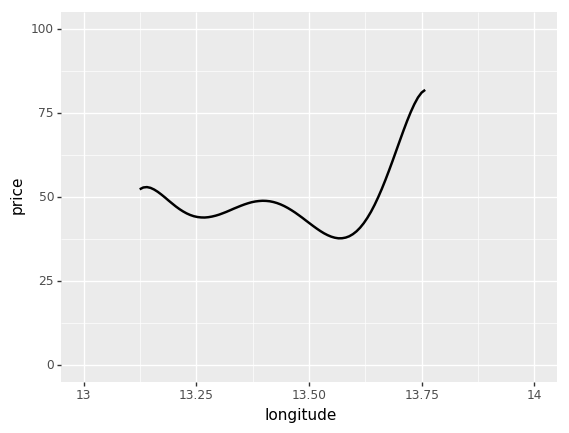

<ggplot: (-9223372029295968147)>

In [28]:
(ggplot(sampled_train, aes('longitude', 'price'))
 + stat_smooth(se=True, method='gpr') + xlim(13, 14) + ylim(0, 100))

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:238: UserWarning: See sklearn.gaussian_process.GaussianProcessRegressor for parameters to pass in as 'method_args'
  "See sklearn.gaussian_process.GaussianProcessRegressor "
/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_smooth : Removed 14 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


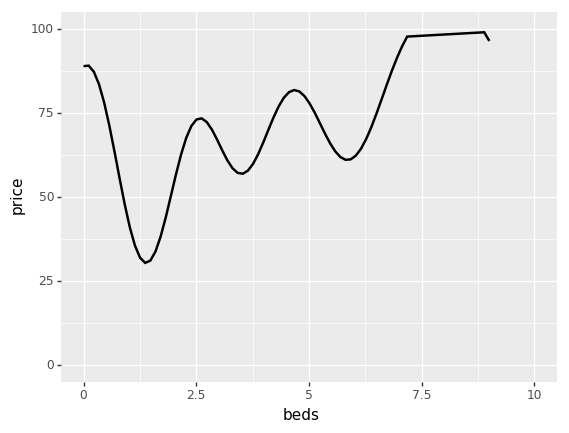

<ggplot: (7560881479)>

In [30]:
(ggplot(sampled_train, aes('beds', 'price'))
 + stat_smooth(se=True, method='gpr') + xlim(0, 10) + ylim(0, 100))

Now from some of these plots, we can detect some trends.  For example, from longitude 13.6 to .75 we can see that the price continually increases.

However, with number of beds we can see that sometimes the price increases with as we add more beds, and sometimes the price decreases.  The issue that is arising, is that as one feature is changing there are likely other features also changing.  So it's unlikely that people prefer fewer beds, but that people prefer fewer beds if it also means they will not have a private room.

### Seeing independent changes

So ideally, we would be able to see how our target variable changes with a change to our feature variable, holding everything else constant.  It turns out, there that allows us to simulate just that.

Let's see this by way of example.  Assume that we wanted to see what we expect the price would be if number of beds is one. 

In [33]:
df_X_val.head()

,host_listings_count,longitude,beds,host_neighbourhood_is_na,summary_is_na,license_is_na,property_type_other,"host_verifications_['email', 'phone']",room_type_Private room
0,1.0,13.451250,1.0,True,False,True,0,0,1
1,1.0,13.409400,1.0,False,False,True,0,0,1
2,4.0,13.304744,1.0,False,False,True,0,0,1
3,1.0,13.304955,2.0,False,False,True,0,0,0
4,1.0,13.471246,1.0,False,False,True,0,0,1


Well one way to do this is to take the our beds feature, fill in our feature variables for beds to always be one and then make predictions for each of our observations and take the average.  Then to see how much beds increases as we move from one to two, we simply set beds equal to 2.  
In this way, we are seeing how much our model is rewarding an increase in beds.  And all of our other data is staying constant, we are simply artificially changing the value of the feature in question.

Plotting this is called a partial dependence plot, and we can use the `pdpbox` library to plot this.

In [34]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=40, max_features='log2')
rfr.fit(df_X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
from pdpbox.pdp import pdp_plot, pdp_isolate
import pdpbox
def plot_pdp(model, X, feature_names, feature, clusters = None):
    iso = pdp_isolate(rfr, X, X.columns, feature)
    return pdp_plot(iso, feature, plot_lines = True, cluster=clusters, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13f0f7150>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1401e5810>})

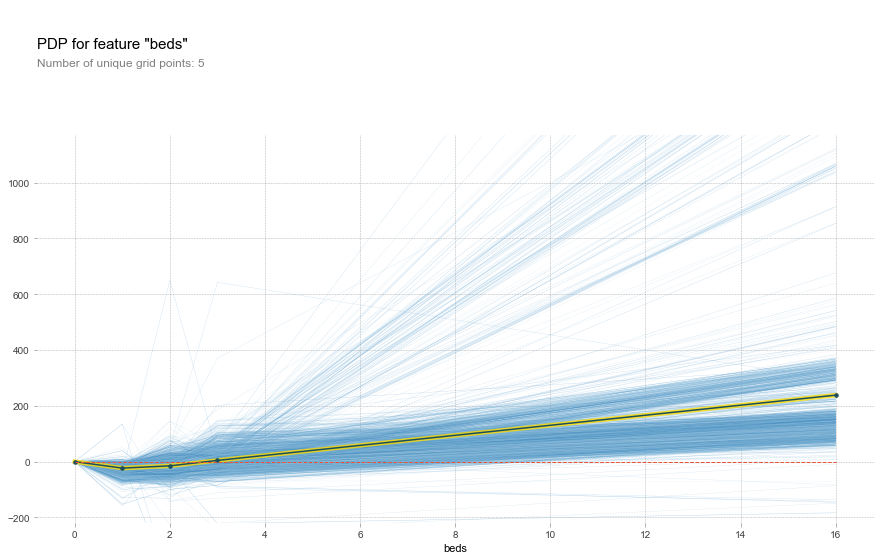

In [36]:
plot_pdp(rfr, df_X_train.sample(2000), df_X_train.columns, 'beds', None)

What we see above is the average value of the target feature in the yellow line, and then then each light blue line displays the predicted value of the target for every observation.

If we would like to simplify the data, we can cluster the paths above.  In the next plot, we'll group our paths into 15 clusters.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c36d54f28>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c35fe6eb8>})

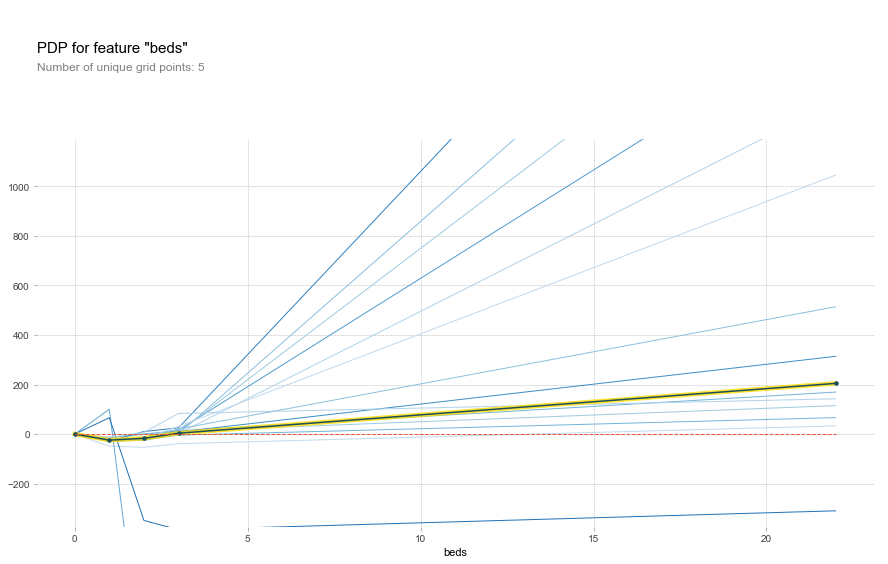

In [38]:
plot_pdp(rfr, df_X_train.sample(2000), df_X_train.columns, 'beds', 15)

We can see that on average, the listing price increases by about 10 for every additional bed.

### Summary

In this lesson, we saw how we can plot individual features against the target variable to see our expected change in the target as our feature inputs change.  We first saw this by just plotting the target against the feature variable.  While we were able to detect patterns in the data, we knew that an increase in a given feature, could be associated with other changes in the data, so we still could not detect a given feature's impact on the data.

We moved next to partial dependence plots.  These plots are created by replacing each feature with a sequential values for the feature.  In this way, we literally hold other features constant while we only change the value of the feature in question.   

### Resouces

[model interpretation](http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html)

[diving into data](http://blog.datadive.net/page/2/)